In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle



In [2]:
# Ucitavanja podataka
airports = pd.read_csv('airports-extended.dat', header=None, names=['id', 'name', 'city', 'country', 'code', 'icao', 'latitude', 'longitude', 'altitude', 'offset', 'dst', 'timezone', 'type', 'source'])
ports = airports[airports['type'] == 'port'][['id', 'latitude', 'longitude']]
railways = airports[airports['type'] == 'station'][['id', 'latitude', 'longitude']]


In [3]:
# Spajanje transporta
transports = pd.concat([ports, railways])


In [4]:
transports

,id,latitude,longitude
6074,7507,22.197075,113.558911
6438,7877,59.323300,18.081000
6439,7878,56.041900,12.691200
6444,7883,60.163056,24.969167
6565,8004,35.539000,133.264000
...,...,...,...
10288,11731,42.135561,24.742210
10289,11732,39.515149,116.707481
10290,11733,28.146282,113.063707
10291,11734,30.607485,114.424268


In [5]:
# Definisanje epsilona
epsilon = 10 / 6371.01  # 10km u radijanima

In [6]:
# Definisanje DBSCAN modela
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(transports[['latitude', 'longitude']]))

In [7]:
# Dodeljivanje klastera
transports['cluster'] = db.labels_

In [8]:
# Funkcija za dobijanje centra svakog klastera
def get_center_point(cluster):
    cluster_points = transports[transports['cluster'] == cluster][['latitude', 'longitude']]
    center_point = cluster_points.mean()
    return center_point.values.tolist()

In [9]:
# Primena funkcije na svaki klaster
transports['center_point'] = transports['cluster'].apply(get_center_point)

In [10]:
transports

,id,latitude,longitude,cluster,center_point
6074,7507,22.197075,113.558911,0,"[22.195402666666666, 113.56570584999999]"
6438,7877,59.323300,18.081000,1,"[59.32665, 18.069528]"
6439,7878,56.041900,12.691200,2,"[56.029109775, 12.63790715]"
6444,7883,60.163056,24.969167,3,"[60.31737880952382, 25.028755619047622]"
6565,8004,35.539000,133.264000,4,"[35.539, 133.264]"
...,...,...,...,...,...
10288,11731,42.135561,24.742210,826,"[42.1355613, 24.74221]"
10289,11732,39.515149,116.707481,611,"[39.5119245, 116.70524050000003]"
10290,11733,28.146282,113.063707,827,"[28.1462817, 113.0637074]"
10291,11734,30.607485,114.424268,828,"[30.607485, 114.42426799999998]"


In [11]:
def get_closest_airport(transport):
    transport_point = transport['center_point']
    airports['distance'] = airports.apply(lambda row: great_circle((row['latitude'], row['longitude']), transport_point).miles, axis=1)
    closest_airport = airports.loc[airports['distance'].idxmin()]['name']
    return closest_airport

In [12]:
# Primena funkcije kako bismo dobili ime najblizeg aerodoroma od svakog centra klastera
transports['closest_airport'] = transports.apply(get_closest_airport, axis=1)

print(transports[['id', 'cluster', 'closest_airport']])

          id  cluster                     closest_airport
6074    7507        0  Macau Outer Harbour Ferry Terminal
6438    7877        1                         T-Centralen
6439    7878        2                   Helsingor Station
6444    7883        3           Koivukyla Railway Station
6565    8004        4                    Sakaiminato Port
...      ...      ...                                 ...
10288  11731      826           Plovdiv South Bus Station
10289  11732      611            Langfang Railway Station
10290  11733      827      Changsha South Railway Station
10291  11734      828               Wuhan Railway Station
10298  11741      664            Nordhavn Railway Station

[1433 rows x 3 columns]


In [16]:
import folium

# Kreiranje mape sa centrom u Evropi (koordinate Londona)
m = folium.Map(location=[51.5074, 0.1278], zoom_start=4)

# Kreiranje markera za svaku centralnu tacku transporta i dodavanje mapi
for index, row in transports.iterrows():
    cluster = row['cluster']
    center_point = row['center_point']
    closest_airport = row['closest_airport']
    popup_text = f"Cluster: {cluster}<br>Closest Airport: {closest_airport}"
    folium.Marker(location=center_point, popup=popup_text).add_to(m)

# Prikazivanje mape
m.save('interaktivna_mapa.html')
m

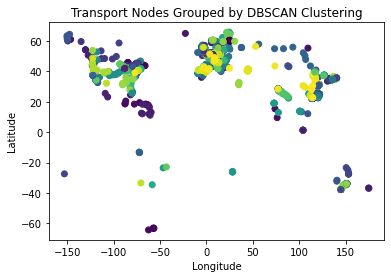

In [18]:
import matplotlib.pyplot as plt

# Plotovanje
plt.scatter(transports['longitude'], transports['latitude'], c=transports['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Transport Nodes Grouped by DBSCAN Clustering')
plt.show()
